In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, r2_score

from funciones import prepare_datasets
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import pymysql
import joblib
import warnings

In [2]:
np.random.seed(42)
warnings.filterwarnings("ignore", category=UserWarning)

# 1.- Connect to DB & Read Data

In [3]:
conn = pymysql.connect(host='localhost', user='tfm_user', password='tfmdatabase1234', db='tfm_database')
df_inmueble = pd.read_sql("SELECT * FROM inmueble", conn)
df_direccion = pd.read_sql("SELECT * FROM direccion", conn)
df_anuncio = pd.read_sql("SELECT * FROM anuncio", conn)

# 2.- Prepare Datasets

In [4]:
inmueble_cols = list(set(df_inmueble.columns) - set(["descripcion", "certificado_energetico"]))
direccion_cols = ["id_direccion", "ha_zonasverdes", "distrito"]
anuncio_cols = ["id_inmueble", "precio", "tipo"]
df_inmueble_ml = df_inmueble[inmueble_cols]
df_direccion_ml = df_direccion[direccion_cols]
df_anuncio_ml = df_anuncio[anuncio_cols]
df_ml = df_anuncio_ml.merge(df_inmueble_ml, on="id_inmueble", how="inner")
df_ml = df_ml.merge(df_direccion_ml, on="id_direccion", how="inner")
df_ml_compra = df_ml[df_ml.tipo == "compra"]
df_ml_alquiler = df_ml[df_ml.tipo == "alquiler"]
df_ml_compra = df_ml_compra[list(set(df_ml_compra.columns) - set(["id_inmueble", "id_direccion", "tipo"]))]
df_ml_alquiler = df_ml_alquiler[list(set(df_ml_alquiler.columns) - set(["id_inmueble", "id_direccion", "tipo"]))]
df_ml2_compra = pd.get_dummies(df_ml_compra)
df_ml2_alquiler = pd.get_dummies(df_ml_alquiler)

# 3.- ML Compra

In [5]:
X_cols = list(set(df_ml2_compra.columns) - set(["precio"]))
y_cols = ["precio"]
X_compra = df_ml2_compra[X_cols]
y_compra = df_ml2_compra[y_cols]
scaler_x_compra, scaler_y_compra, X_train_compra, X_test_compra, y_train_compra, y_test_compra = prepare_datasets(X_compra, y_compra)

## 3.1.- Linear Regression

In [6]:
model_linear_compra = LinearRegression()

model_linear_compra.fit(X_train_compra, y_train_compra)

LinearRegression()

In [7]:
prediction_linear_test_compra = model_linear_compra.predict(X_test_compra)
prediction_linear_train_compra = model_linear_compra.predict(X_train_compra)

linear_reg_test_mse_compra = mean_squared_error(scaler_y_compra.transform(y_test_compra), scaler_y_compra.transform(prediction_linear_test_compra))
linear_reg_train_mse_compra = mean_squared_error(scaler_y_compra.transform(y_train_compra), scaler_y_compra.transform(prediction_linear_train_compra))

print(f"Train MSE -- Linear Regression: {linear_reg_train_mse_compra}")
print(f"Test MSE -- Linear Regression: {linear_reg_test_mse_compra}")

Train MSE -- Linear Regression: 1.3418292359023734e-17
Test MSE -- Linear Regression: 1.3871191320112186e-17


In [8]:
linear_reg_test_score_compra = r2_score(y_test_compra, prediction_linear_test_compra)
linear_reg_train_score_compra = r2_score(y_train_compra, prediction_linear_train_compra)

print(f"Train Score -- Linear Regression: {linear_reg_train_score_compra}")
print(f"Test Score -- Linear Regression: {linear_reg_test_score_compra}")

Train Score -- Linear Regression: 0.8247503435013313
Test Score -- Linear Regression: 0.8217716125598613


## 3.2.- Random Forest

In [9]:
model_rand_forest_compra = RandomForestRegressor()
model_rand_forest_compra.fit(X_train_compra, y_train_compra)

prediction_rand_forest_test_compra = model_rand_forest_compra.predict(X_test_compra)
prediction_rand_forest_train_compra = model_rand_forest_compra.predict(X_train_compra)


In [10]:
random_forest_test_mse_compra = mean_squared_error(scaler_y_compra.transform(y_test_compra), scaler_y_compra.transform(prediction_rand_forest_test_compra.reshape(-1,1)))
random_forest_train_mse_compra = mean_squared_error(scaler_y_compra.transform(y_train_compra), scaler_y_compra.transform(prediction_rand_forest_train_compra.reshape(-1,1)))

print(f"Train MSE -- Random Forest: {random_forest_train_mse_compra}")
print(f"Test MSE -- Random Forest: {random_forest_test_mse_compra}")

Train MSE -- Random Forest: 1.3745110221211376e-19
Test MSE -- Random Forest: 8.027942032738678e-19


In [11]:
random_forest_test_score_compra = r2_score(y_test_compra, prediction_rand_forest_test_compra)
random_forest_train_score_compra = r2_score(y_train_compra, prediction_rand_forest_train_compra)

print(f"Train Score -- Random Forest: {random_forest_train_score_compra}")
print(f"Test Score -- Random Forest: {random_forest_test_score_compra}")

Train Score -- Random Forest: 0.9982048193761679
Test Score -- Random Forest: 0.9896850448534218


## 3.3.- XGBoost

In [12]:
model_xgb_regressor_compra = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=300, random_state=42)
model_xgb_regressor_compra.fit(X_train_compra, y_train_compra)

prediction_xgb_test_compra = model_xgb_regressor_compra.predict(X_test_compra)
prediction_xgb_train_compra = model_xgb_regressor_compra.predict(X_train_compra)

In [13]:
xgb_test_mse_compra = mean_squared_error(scaler_y_compra.transform(y_test_compra), scaler_y_compra.transform(prediction_xgb_test_compra.reshape(-1,1)))
xgb_train_mse_compra = mean_squared_error(scaler_y_compra.transform(y_train_compra), scaler_y_compra.transform(prediction_xgb_train_compra.reshape(-1,1)))

print(f"Train MSE -- Random Forest: {xgb_train_mse_compra}")
print(f"Test MSE -- Random Forest: {xgb_test_mse_compra}")

Train MSE -- Random Forest: 6.395735491362799e-19
Test MSE -- Random Forest: 1.2832034189134235e-18


In [14]:
xgb_test_score_compra = r2_score(y_test_compra, prediction_xgb_test_compra)
xgb_train_score_compra = r2_score(y_train_compra, prediction_xgb_train_compra)

print(f"Train Score -- Random Forest: {xgb_train_score_compra}")
print(f"Test Score -- Random Forest: {xgb_test_score_compra}")

Train Score -- Random Forest: 0.9918643441795556
Test Score -- Random Forest: 0.9837624600560517


## 3.4.- SVM 

In [15]:
model_svm_compra = SVR(kernel='linear', C=1.0, epsilon=0.2)
model_svm_compra.fit(X_train_compra, y_train_compra)


prediction_svm_test_compra = model_svm_compra.predict(X_test_compra)
prediction_svm_train_compra = model_svm_compra.predict(X_train_compra)

In [16]:
svm_test_mse_compra = mean_squared_error(scaler_y_compra.transform(y_test_compra), scaler_y_compra.transform(prediction_svm_test_compra.reshape(-1,1)))
svm_train_mse_compra = mean_squared_error(scaler_y_compra.transform(y_train_compra), scaler_y_compra.transform(prediction_svm_train_compra.reshape(-1,1)))

print(f"Train MSE -- Random Forest: {svm_train_mse_compra}")
print(f"Test MSE -- Random Forest: {svm_test_mse_compra}")

Train MSE -- Random Forest: 7.396326982530052e-17
Test MSE -- Random Forest: 7.397146348294955e-17


In [17]:
svm_test_score_compra = r2_score(y_test_compra, prediction_svm_test_compra)
svm_train_score_compra = r2_score(y_train_compra, prediction_svm_train_compra)

print(f"Train Score -- Random Forest: {svm_train_score_compra}")
print(f"Test Score -- Random Forest: {svm_test_score_compra}")

Train Score -- Random Forest: 0.03400244355744675
Test Score -- Random Forest: 0.049554263294638856


# 4.- ML Alquiler

In [18]:
X_cols = list(set(df_ml2_alquiler.columns) - set(["precio"]))
y_cols = ["precio"]
X_alquiler = df_ml2_alquiler[X_cols]
y_alquiler = df_ml2_alquiler[y_cols]
scaler_x_alquiler, scaler_y_alquiler, X_train_alquiler, X_test_alquiler, y_train_alquiler, y_test_alquiler = prepare_datasets(X_alquiler, y_alquiler)

## 4.1.- Linear Regression

In [19]:
model_linear_alquiler = LinearRegression()
model_linear_alquiler.fit(X_train_alquiler, y_train_alquiler)

prediction_linear_test_alquiler = model_linear_alquiler.predict(X_test_alquiler)
prediction_linear_train_alquiler = model_linear_alquiler.predict(X_train_alquiler)


In [20]:
linear_reg_test_mse_alquiler = mean_squared_error(scaler_y_alquiler.transform(y_test_alquiler), scaler_y_alquiler.transform(prediction_linear_test_alquiler))
linear_reg_train_mse_alquiler = mean_squared_error(scaler_y_alquiler.transform(y_train_alquiler), scaler_y_alquiler.transform(prediction_linear_train_alquiler))

print(f"Train MSE -- Linear Regression: {linear_reg_train_mse_alquiler}")
print(f"Test MSE -- Linear Regression: {linear_reg_test_mse_alquiler}")

Train MSE -- Linear Regression: 4.176896726392627e-09
Test MSE -- Linear Regression: 4.004060753237999e-09


In [21]:
linear_reg_test_score_alquiler = r2_score(y_test_alquiler, prediction_linear_test_alquiler)
linear_reg_train_score_alquiler = r2_score(y_train_alquiler, prediction_linear_train_alquiler)

print(f"Train Score -- Linear Regressiont: {linear_reg_train_score_alquiler}")
print(f"Test Score -- Linear Regression: {linear_reg_test_score_alquiler}")

Train Score -- Linear Regressiont: 0.7586081736612511
Test Score -- Linear Regression: 0.7690766222214697


## 4.2.- Random Forest 

In [22]:
model_rand_forest_alquiler = RandomForestRegressor()
model_rand_forest_alquiler.fit(X_train_alquiler, y_train_alquiler)

prediction_rand_forest_test_alquiler = model_rand_forest_alquiler.predict(X_test_alquiler)
prediction_rand_forest_train_alquiler = model_rand_forest_alquiler.predict(X_train_alquiler)

In [23]:
random_forest_test_mse_alquiler = mean_squared_error(scaler_y_alquiler.transform(y_test_alquiler), scaler_y_alquiler.transform(prediction_rand_forest_test_alquiler.reshape(-1,1)))
random_forest_train_mse_alquiler = mean_squared_error(scaler_y_alquiler.transform(y_train_alquiler), scaler_y_alquiler.transform(prediction_rand_forest_train_alquiler.reshape(-1,1)))

print(f"Train MSE -- Random Forest: {random_forest_train_mse_alquiler}")
print(f"Test MSE -- Random Forest: {random_forest_test_mse_alquiler}")

Train MSE -- Random Forest: 7.46899808321298e-11
Test MSE -- Random Forest: 4.188908594658047e-10


In [24]:
random_forest_test_score_alquiler = r2_score(y_test_alquiler, prediction_rand_forest_test_alquiler)
random_forest_train_score_alquiler = r2_score(y_train_alquiler, prediction_rand_forest_train_alquiler)

print(f"Train Score -- Random Forest: {random_forest_train_score_alquiler}")
print(f"Test Score -- Random Forest: {random_forest_test_score_alquiler}")

Train Score -- Random Forest: 0.9956835057069163
Test Score -- Random Forest: 0.9758416022758473


## 4.3.- XGBoost

In [25]:
moswl_xgb_regressor_alquiler = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=300, random_state=42)
moswl_xgb_regressor_alquiler.fit(X_train_alquiler, y_train_alquiler)

prediction_xgb_test_alquiler = moswl_xgb_regressor_alquiler.predict(X_test_alquiler)
prediction_xgb_train_alquiler = moswl_xgb_regressor_alquiler.predict(X_train_alquiler)

In [26]:
xgb_test_mse_alquiler = mean_squared_error(scaler_y_alquiler.transform(y_test_alquiler), scaler_y_alquiler.transform(prediction_xgb_test_alquiler.reshape(-1,1)))
xgb_train_mse_alquiler = mean_squared_error(scaler_y_alquiler.transform(y_train_alquiler), scaler_y_alquiler.transform(prediction_xgb_train_alquiler.reshape(-1,1)))

print(f"Train MSE -- Random Forest: {xgb_train_mse_alquiler}")
print(f"Test MSE -- Random Forest: {xgb_test_mse_alquiler}")

Train MSE -- Random Forest: 4.767891730134386e-10
Test MSE -- Random Forest: 8.837298952102154e-10


In [27]:
xgb_test_score_alquiler = r2_score(y_test_alquiler, prediction_xgb_test_alquiler)
xgb_train_score_alquiler = r2_score(y_train_alquiler, prediction_xgb_train_alquiler)

print(f"Train Score -- Random Forest: {xgb_train_score_alquiler}")
print(f"Test Score -- Random Forest: {xgb_test_score_alquiler}")

Train Score -- Random Forest: 0.9724454268401235
Test Score -- Random Forest: 0.9490332219244543


## 4.4.- SVM

In [28]:
model_svm_alquiler = SVR(kernel='linear', C=1.0, epsilon=0.2)
model_svm_alquiler.fit(X_train_alquiler, y_train_alquiler)

prediction_svm_test_alquiler = model_svm_alquiler.predict(X_test_alquiler)
prediction_svm_train_alquiler = model_svm_alquiler.predict(X_train_alquiler)

In [29]:
svm_test_mse_alquiler = mean_squared_error(scaler_y_alquiler.transform(y_test_alquiler), scaler_y_alquiler.transform(prediction_svm_test_alquiler.reshape(-1,1)))
svm_train_mse_alquiler = mean_squared_error(scaler_y_alquiler.transform(y_train_alquiler), scaler_y_alquiler.transform(prediction_svm_train_alquiler.reshape(-1,1)))

print(f"Train MSE -- Random Forest: {svm_train_mse_alquiler}")
print(f"Test MSE -- Random Forest: {svm_test_mse_alquiler}")

Train MSE -- Random Forest: 4.4062015512546514e-09
Test MSE -- Random Forest: 4.206896353074001e-09


In [30]:
svm_test_score_alquiler = r2_score(y_test_alquiler, prediction_svm_test_alquiler)
svm_train_score_alquiler = r2_score(y_train_alquiler, prediction_svm_train_alquiler)

print(f"Train Score -- Random Forest: {svm_train_score_alquiler}")
print(f"Test Score -- Random Forest: {svm_test_score_alquiler}")

Train Score -- Random Forest: 0.7453561556949064
Test Score -- Random Forest: 0.757378627427065


# 5.- Save Models

In [41]:
joblib.dump(scaler_x_alquiler, "scaler_x_alquiler.joblib")
joblib.dump(scaler_x_compra, "scaler_x_compra.joblib")
joblib.dump(model_rand_forest_alquiler, "model_alquiler.joblib")
joblib.dump(model_rand_forest_compra, "model_compra.joblib")
joblib.dump(scaler_y_alquiler, "scaler_y_alquiler.joblib")
joblib.dump(scaler_y_compra, "scaler_y_compra.joblib")

['model_compra4.joblib']

# 6.- Plots

In [54]:
data_alquiler = [[linear_reg_train_score_alquiler, linear_reg_train_mse_alquiler, "Linear Regression", "Train"],
                 [linear_reg_test_score_alquiler, linear_reg_test_mse_alquiler, "Linear Regression", "Test"],
                 [random_forest_train_score_alquiler, random_forest_train_mse_alquiler, "Random Forest", "Train"],
                 [random_forest_test_score_alquiler, random_forest_test_mse_alquiler, "Random Forest", "Test"],
                 [xgb_train_score_alquiler, xgb_train_mse_alquiler, "XGBoost", "Train"],
                 [xgb_test_score_alquiler, xgb_test_mse_alquiler, "XGBoost", "Test"],
                 [svm_train_score_alquiler, svm_train_mse_alquiler, "SVM", "Train"],
                 [svm_test_score_alquiler, svm_test_mse_alquiler, "SVM", "Test"]]

In [55]:
df_plot_alquiler = pd.DataFrame(data_alquiler, columns=["Score", "MSE", "Modelo", "Datos"])

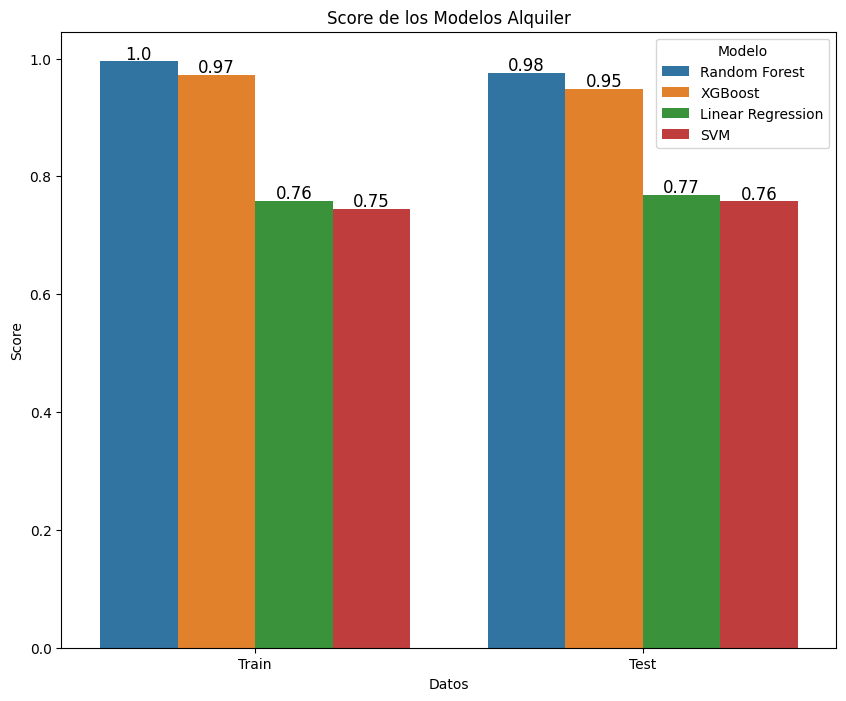

In [66]:
plt.figure(figsize=(10, 8))
ax = sns.barplot(data = df_plot_alquiler.sort_values(by="Score", ascending=False), x="Datos", y="Score", hue="Modelo")
for p in ax.patches:
    value = round(p.get_height(), 2)  # Round to 2 decimal places
    ax.annotate(f'{value}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title("Score de los Modelos Alquiler")
plt.show()

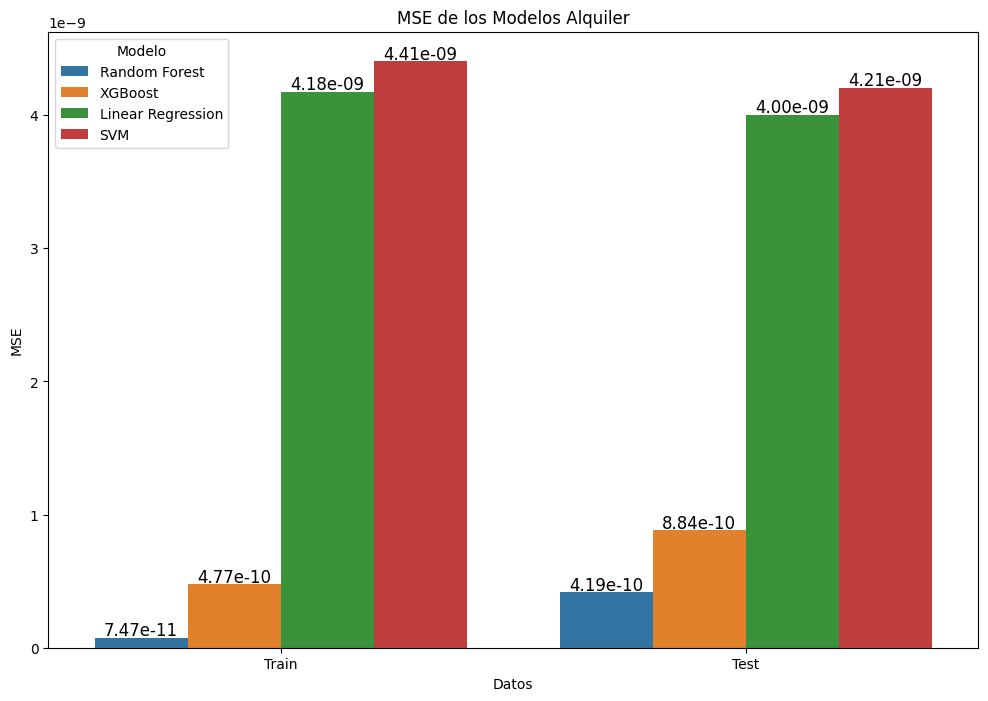

In [67]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(data = df_plot_alquiler.sort_values(by="MSE"), x="Datos", y="MSE", hue="Modelo")
for p in ax.patches:
    value = "{:.2e}".format(p.get_height())  # Round to 2 decimal places
    ax.annotate(f'{value}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title("MSE de los Modelos Alquiler")
plt.show()

In [68]:
data_compra = [[linear_reg_train_score_compra, linear_reg_train_mse_compra, "Linear Regression", "Train"],
               [linear_reg_test_score_compra, linear_reg_test_mse_compra, "Linear Regression", "Test"],
               [random_forest_train_score_compra, random_forest_train_mse_compra, "Random Forest", "Train"],
               [random_forest_test_score_compra, random_forest_test_mse_compra, "Random Forest", "Test"],
               [xgb_train_score_compra, xgb_train_mse_compra, "XGBoost", "Train"],
               [xgb_test_score_compra, xgb_test_mse_compra, "XGBoost", "Test"],
               [svm_train_score_compra, svm_train_mse_compra, "SVM", "Train"],
               [svm_test_score_compra, svm_test_mse_compra, "SVM", "Test"]]

In [69]:
df_plot_compra = pd.DataFrame(data_compra, columns=["Score", "MSE", "Modelo", "Datos"])

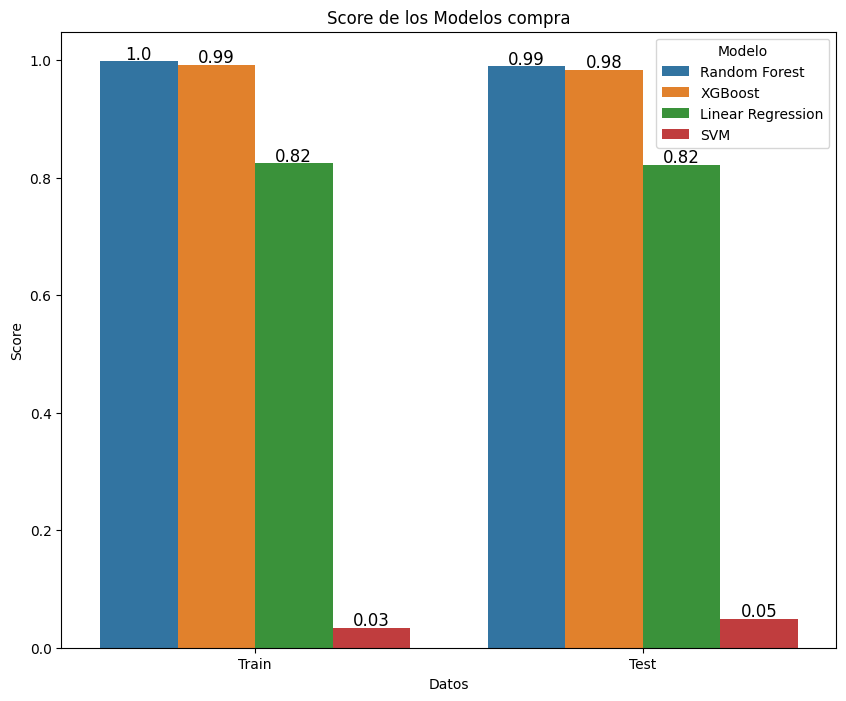

In [72]:
plt.figure(figsize=(10, 8))
ax = sns.barplot(data = df_plot_compra.sort_values(by="Score", ascending=False), x="Datos", y="Score", hue="Modelo")
for p in ax.patches:
    value = round(p.get_height(), 2)  # Round to 2 decimal places
    ax.annotate(f'{value}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title("Score de los Modelos compra")
plt.show()

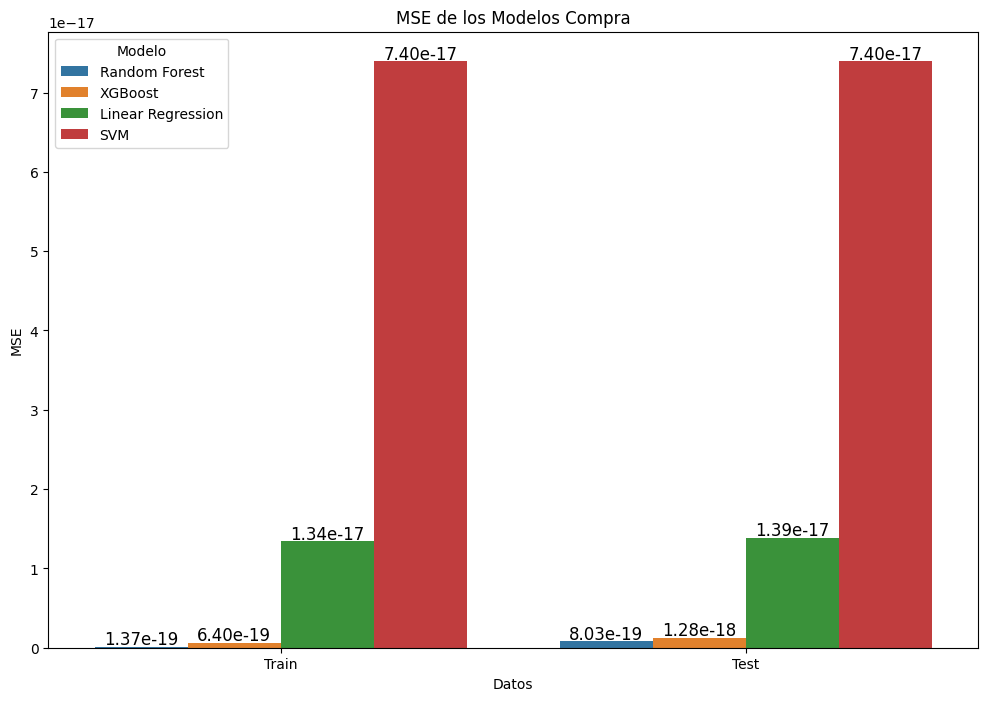

In [73]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(data = df_plot_compra.sort_values(by="MSE"), x="Datos", y="MSE", hue="Modelo")
for p in ax.patches:
    value = "{:.2e}".format(p.get_height())  # Round to 2 decimal places
    ax.annotate(f'{value}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title("MSE de los Modelos Compra")
plt.show()